# RI Exploration

Let's look at the RoutineImmunization component and compare several scenarios.

1. 2 node, 2 year SEIR model with no RI
2. 2 node, 2 year SEIR model with "reasonable" RI of 70% coverage
3. 2 node, 2 year SEIR model with 70% coverage in one node and 0% coverage in the other node
4. 2 node, 2 year SEIR model with coverage ramping up from 0% to 70% over the course of two years
5. dials: 0 <= coverage <= 1 and 1 <= time-to-vaccination <= 365 (arbitrary)
    1. 2 node, 2 year SEIR model with no initial coverage switching to 100% coverage the day after birth at one year
    2. 2 node, 2 year SEIR model with no initial coverage switching to 100% coverage at a normal time: 9 months (274 days)
    3. 2 node, 2 year SEIR model with no initial coverage switching to 100% coverage anywhere from 3 (91 days) to 15 months (456)


## 2 Node, 2 Year SEIR Model with No RI

model.people.count=200000
model.people.capacity=214128


SEIR 2 Node 2 Year No RI: 100%|██████████| 730/730 [00:01<00:00, 558.07it/s]


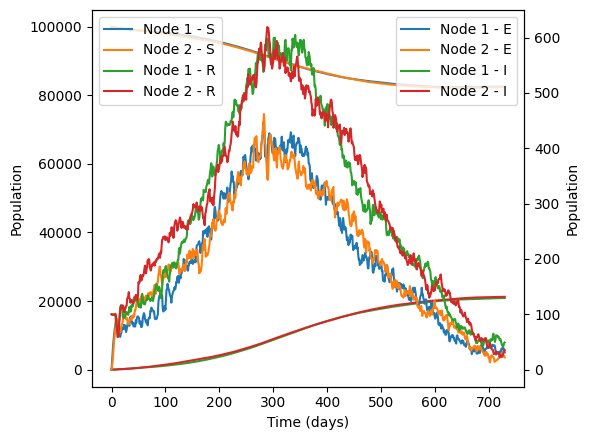

Final Susceptible: 165,023
Final Recovered:    42,135


In [ ]:
import numpy as np
from laser.generic import SEIR
from laser.generic import Model
from laser.core.utils import grid
from laser.core import PropertySet
from laser.core import distributions
from laser.generic.newutils import ValuesMap
from laser.core.demographics import load_pyramid_csv
from laser.core.demographics import AliasedDistribution
from laser.core.demographics import KaplanMeierEstimator

POPULATION = 200_000
INITIAL_INFECTIONS = 100
ROWS = 1
COLS = 2

scenario = grid(M=ROWS, N=COLS, population_fn=lambda x, y: POPULATION // (ROWS * COLS))
scenario["S"] = scenario.population - INITIAL_INFECTIONS
scenario["E"] = 0
scenario["I"] = INITIAL_INFECTIONS
scenario["R"] = 0

R0 = 1.125
exposure_mean = 7.0
exposure_scale = 1.0
infectious_mean = 10.0
infectious_scale = 1.5
beta = R0 / infectious_mean

NTICKS = 730
parameters = PropertySet({"nticks": NTICKS, "beta": beta})
birthrates = ValuesMap.from_scalar(35.0, 2, NTICKS).values
model = Model(scenario, parameters, birthrates=birthrates, name="SEIR 2 Node 2 Year No RI")

expdurdist = distributions.normal(loc=exposure_mean, scale=exposure_scale)
infdurdist = distributions.normal(loc=infectious_mean, scale=infectious_scale)

p = load_pyramid_csv("Nigeria-Distribution-2020.csv") # https://www.populationpyramid.net/nigeria/2020/
p = p[:,2] + p[:,3]  # Both sexes
pyramid = AliasedDistribution(p)

# https://population.un.org/wpp/downloads?folder=Standard%20Projections&group=Mortality WPP2024_MORT_F04_1_LIFE_TABLE_SURVIVORS_BOTH_SEXES.xlsx
data = np.loadtxt("Nigeria-Survival-2020.csv", delimiter=",", usecols=1).cumsum()
survival = KaplanMeierEstimator(data)

model.components = [
    SEIR.Susceptible(model),
    SEIR.Recovered(model),
    SEIR.Infectious(model, infdurdist, infdurmin=1),
    SEIR.Exposed(model, expdurdist, infdurdist, expdurmin=1, infdurmin=1),
    SEIR.Transmission(model, expdurdist=expdurdist, expdurmin=1),
    SEIR.VitalDynamics(model, birthrates, pyramid, survival),
]

print(f"{model.people.count=}")
print(f"{model.people.capacity=}")

model.run("SEIR 2 Node 2 Year No RI")

import matplotlib.pyplot as plt

def plot_traces(model, zoom=1.0):
    figure = plt.figure(figsize=(zoom*6, zoom*4.5))
    axes = [figure.add_subplot(1, 1, 1)]
    axes.append(axes[0].twinx())

    for channel, axis in [('S', 0), ('E', 1), ('I', 1), ('R', 0)]:
        for node in range(model.nodes.count):
            data = getattr(model.nodes, channel)[:,node]
            label = f"Node {node+1} - {channel}"
            axes[axis].plot(data, label=label)

    axes[0].set_xlabel("Time (days)")
    axes[0].set_ylabel("Population")
    axes[1].set_ylabel("Population")
    axes[0].legend(loc="upper left")
    axes[1].legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    return


plot_traces(model)

def print_summary(model):
    final_S = model.nodes.S[-1,:].sum()
    final_R = model.nodes.R[-1,:].sum()
    print(f"Final Susceptible: {final_S:7,}")
    print(f"Final Recovered:   {final_R:7,}")

print_summary(model)


In [14]:
from collections import namedtuple

seeds = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144]

baseline = []
for index, seed in enumerate(seeds):
    parameters |= {"prng_seed": seed}
    model = Model(scenario, parameters, birthrates=birthrates, name="SEIR 2 Node 2 Year No RI")
    model.components = [
        SEIR.Susceptible(model),
        SEIR.Recovered(model),
        SEIR.Infectious(model, infdurdist, infdurmin=1),
        SEIR.Exposed(model, expdurdist, infdurdist, expdurmin=1, infdurmin=1),
        SEIR.Transmission(model, expdurdist=expdurdist, expdurmin=1),
        SEIR.VitalDynamics(model, birthrates, pyramid, survival),
    ]
    model.run(f"{index+1:2}/{len(seeds):2} SEIR 2 Node 2 Year No RI - Seed {seed:3}")
    # baseline doesn't have RI, ri_doses and ri_immunized are zeros
    baseline.append((model.nodes.S, model.nodes.R, np.zeros_like(model.nodes.newly_infected), np.zeros_like(model.nodes.newly_infected)))

Results = namedtuple("Results", ["mean_S", "mean_R", "mean_ri_doses", "mean_ri_immunized"])

# Get means from results
def mean_results(results):
    sum_S = np.zeros_like(results[0][0])
    sum_R = np.zeros_like(results[0][1])
    sum_ri_doses = np.zeros_like(results[0][2])
    sum_ri_immunized = np.zeros_like(results[0][3])
    for S, R, ri_doses, ri_immunized in results:
        sum_S += S
        sum_R += R
        sum_ri_doses += ri_doses
        sum_ri_immunized += ri_immunized
    n = len(results)
    mean_S = sum_S / n
    mean_R = sum_R / n
    mean_ri_doses = sum_ri_doses / n
    mean_ri_immunized = sum_ri_immunized / n
    return Results(mean_S, mean_R, mean_ri_doses, mean_ri_immunized)

def plot_results(results, zoom=1.0):
    figure = plt.figure(figsize=(zoom*6, zoom*4.5))
    axes = [figure.add_subplot(1, 1, 1)]
    axes.append(axes[0].twinx())

    for channel, axis in [("mean_S", 0), ("mean_R", 0), ("mean_ri_doses", 1), ("mean_ri_immunized", 1)]:
        for node in range(model.nodes.count):
            data = getattr(results, channel)[:,node]
            label = f"Node {node+1} - {channel}"
            axes[axis].plot(data, label=label)

    axes[0].set_xlabel("Time (days)")
    axes[0].set_ylabel("Population")
    axes[1].set_ylabel("Population")
    axes[0].legend(loc="outside left")
    axes[1].legend(loc="outside right")
    plt.tight_layout()
    plt.show()

    return

plot_results(mean_results(baseline))

10/11 SEIR 2 Node 2 Year No RI - Seed  89:  99%|█████████▉| 725/730 [00:00<00:00, 1032.91it/s]


ValueError: frame.add() exceeds capacity (self._count=214124 + count=np.int64(16) > self._capacity=214129)

## 2 Node, 2 Year SEIR Model with 70% RI Coverage Around 9 Months

200000 agents in 2 nodes: 100%|██████████| 730/730 [00:01<00:00, 697.01it/s]


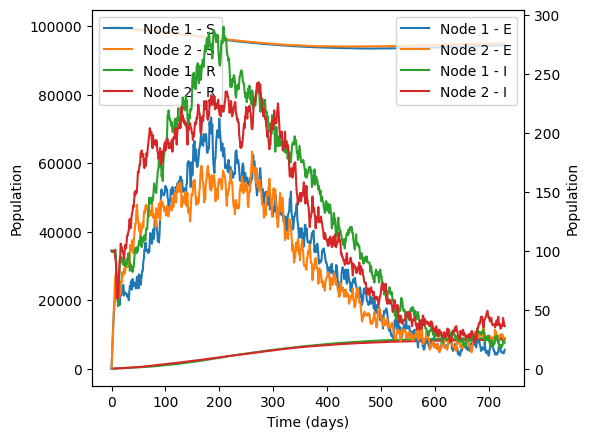

Final Susceptible: 189,539
Final Recovered:    17,509


In [2]:
from laser.generic.immunization import RoutineImmunizationEx

def run_with_ri(coverage_fn, dose_timing_dist=None, dose_timing_min=None):
    model = Model(scenario, parameters, birthrates=birthrates, name="SEIR 2 Node 2 Year 70% RI")

    if dose_timing_dist is None:
        dose_timing_dist = distributions.normal(loc=274, scale=30)  # Around 9 months
    if dose_timing_min is None:
        dose_timing_min = 183  # Minimum 6 months

    model.components = [
        SEIR.Susceptible(model),
        SEIR.Recovered(model),
        SEIR.Infectious(model, infdurdist, infdurmin=1),
        SEIR.Exposed(model, expdurdist, infdurdist, expdurmin=1, infdurmin=1),
        SEIR.Transmission(model, expdurdist=expdurdist, expdurmin=1),
        SEIR.VitalDynamics(model, birthrates, pyramid, survival),
        RoutineImmunizationEx(model, coverage_fn=coverage_fn, dose_timing_dist=dose_timing_dist, dose_timing_min=dose_timing_min),
    ]

    model.run()
    plot_traces(model)
    print_summary(model)

    return model

coverage_constant = distributions.constant_float(value=0.7) # 70% coverage
model = run_with_ri(coverage_constant)


## 2 node, 2 year SEIR model with 70% coverage in one node and 0% coverage in the other node


200000 agents in 2 nodes: 100%|██████████| 730/730 [00:01<00:00, 663.89it/s]


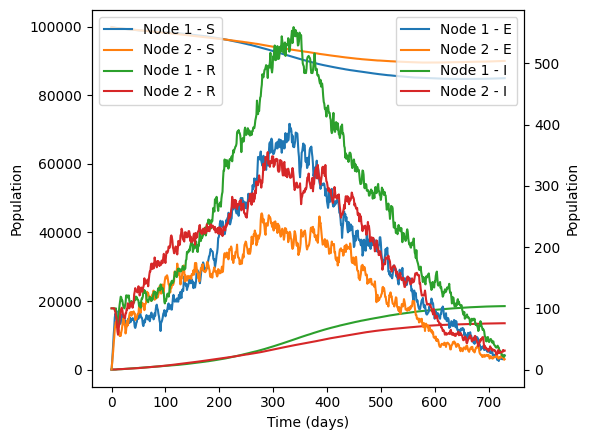

Final Susceptible: 175,040
Final Recovered:    32,038


In [3]:
import numba as nb

@nb.njit(nogil=True)
def coverage_split(tick, node):
    if node == 0:
        return 0.0  # 0% coverage in node 0
    # else:
    return 0.7  # 70% coverage in node 1

model = run_with_ri(coverage_split)


## 2 node, 2 year SEIR model with coverage ramping up from 0% to 70% over the course of two years


200000 agents in 2 nodes: 100%|██████████| 730/730 [00:01<00:00, 693.94it/s]


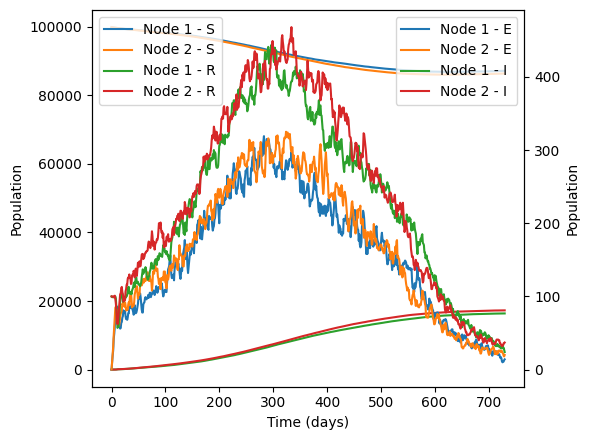

Final Susceptible: 173,540
Final Recovered:    33,660


In [4]:
@nb.njit(nogil=True)
def coverage_ramp(tick, node):
    ramp = min(tick, 730) / 730.0
    coverage = 0.7 * ramp
    return coverage  # ramped coverage in node 1

model = run_with_ri(coverage_ramp)


## 2 node, 2 year SEIR model with no initial coverage switching to 100% coverage the day after birth at one year


200000 agents in 2 nodes: 100%|██████████| 730/730 [00:01<00:00, 697.74it/s]


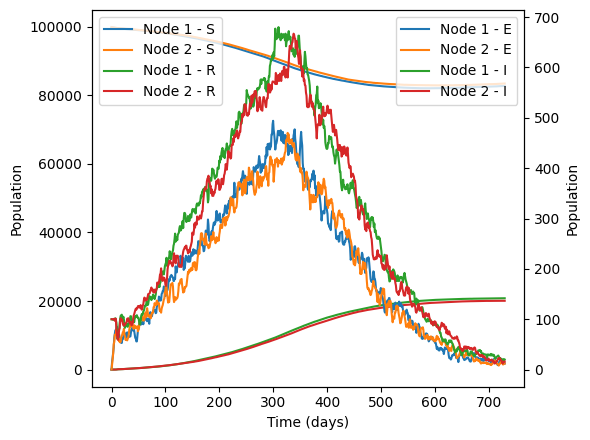

Final Susceptible: 166,216
Final Recovered:    40,879


In [5]:
@nb.njit(nogil=True)
def coverage_switch(tick, node):
    if tick < 365:
        return 0.0  # 0% coverage initially
    # else:
    return 1.0  # 100% coverage after 1 year

model = run_with_ri(coverage_switch, dose_timing_dist=distributions.constant_int(1), dose_timing_min=1)


## 2 node, 2 year SEIR model with no initial coverage switching to 100% coverage at a normal time: 9 months (274 days)


200000 agents in 2 nodes: 100%|██████████| 730/730 [00:00<00:00, 805.40it/s]


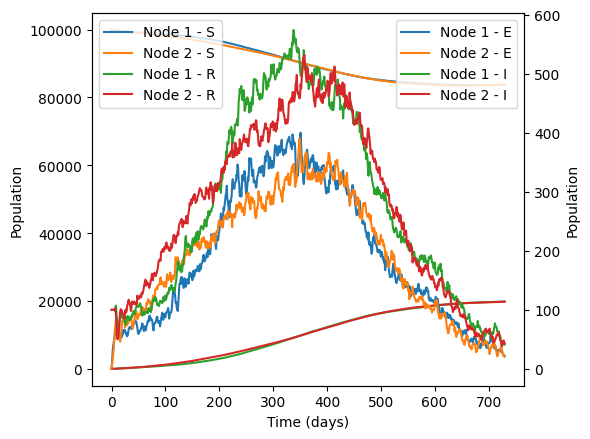

Final Susceptible: 167,512
Final Recovered:    39,578


In [6]:
model = run_with_ri(coverage_switch, dose_timing_dist=distributions.constant_int(274), dose_timing_min=274)


## 2 node, 2 year SEIR model with no initial coverage switching to 100% coverage anywhere from 3 (91 days) to 15 months (456)

200000 agents in 2 nodes: 100%|██████████| 730/730 [00:01<00:00, 687.24it/s]


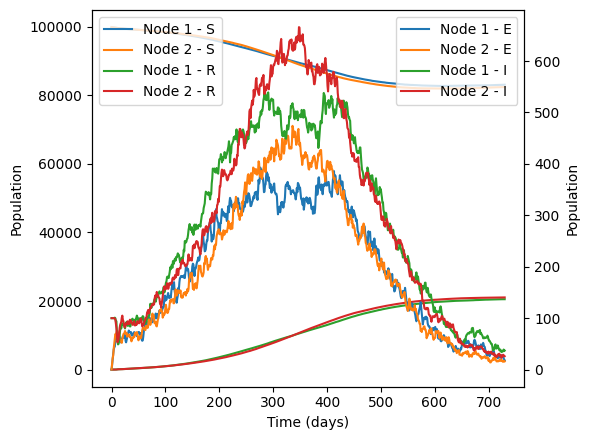

Final Susceptible: 165,539
Final Recovered:    41,584


In [7]:
@nb.njit(nogil=True)
def coverage_switch(tick, node):
    if tick < 365:
        return 0.0  # 0% coverage initially
    # else:
    return 1.0  # 100% coverage after 1 year

model = run_with_ri(coverage_switch, dose_timing_dist=distributions.normal(loc=274, scale=45), dose_timing_min=183)
